# XCEPTION + DEC Model on Galaxy Zoo Dataset

This notebook loads the xception model and tries to extract features from the Xception Model for all the galaxy zoo images. Then it invokes a DEC model on top of the features extracted to perform the required clustering. This notebook acts as a step by step guide through the whole process and also as a way of performing the experiment for the current research of clustering galaxies.

### Importing required Libaries

Importing the required libraries and modules so that they can be used in the notebook

In [1]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
# loading the requirements for the Xception model
from keras.applications.xception import Xception
from keras.applications.xception import absolute_import, decode_predictions, preprocess_input
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
# Loading the DEC module cloned from github
from DEC.model import *
from DEC.metrics import *
from xception_dec_datagenerator import XceptionDataGenerator
# Importing the utilities
from utils.file_utils import *
from PIL import Image
# Using scikit-image  resize function for resizing the image from original size to 224 X 224
from skimage.transform import resize
# Train Test split from sklearn
from sklearn.model_selection import train_test_split
from shutil import copy2
# For visualization of images and for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Xception Model

First we load the Xception model into the computer memory using the Keras library. Because we are focusing on extracting features from the model we do not include the topmost layer. However we do use the imagenet weights for the model. Also because we want a 1-D vector form of the features we do use the pooling layer at the end.

In [3]:
input_tensor_shape = (224, 224, 3)
base_xception_model = Xception(weights = 'imagenet', input_shape = input_tensor_shape, include_top = False, pooling='avg')
base_xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

The input shape of our base xception model is: 224 X 224 X 3. That is a 3 channel square image with side 224 pixels.
The output shape of the base xception model is: 2048 X 1. It is a 1-D vector representing the features learned by the model

### Loading the Galaxy Zoo data

We now start loading the galaxy zoo data into memory. First we load the label file and then start loading the corresponding images such that we can assign the corresponding label to them

In [4]:
all_labels = pd.read_csv(f'../data/galaxy_zoo/training_solutions_rev1.csv')
all_labels.head()

FileNotFoundError: [Errno 2] File b'../data/galaxy_zoo/training_solutions_rev1.csv' does not exist: b'../data/galaxy_zoo/training_solutions_rev1.csv'

In [ ]:
# Assuming the follwing column names:
elliptical_galaxy_col_name = 'Class1.1'
spiral_galaxy_col_name = 'Class1.2'

# elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] > all_labels[spiral_galaxy_col_name]]['GalaxyID'], dtype=str)
elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] >= 0.5]['GalaxyID'], dtype=str)
# spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > all_labels[elliptical_galaxy_col_name]]['GalaxyID'], dtype=str)
spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > 0.5]['GalaxyID'], dtype=str)

In [ ]:
# Finding the number of images for each type of galaxy
print(f'Number Elliptical Galaxies: {elliptical_galaxy_ids.shape[0]}')
print(f'Number Spiral Galaxies: {spiral_galaxy_ids.shape[0]}')

### Elliptical Galaxy

#### Visualization

In [ ]:
elliptical_galaxy_ids.head()

In [ ]:
# Not using cv2 because it reads the image channels in a reverse order (BGR instead of RGB)
# elliptical_image = cv2.imread(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1/100053.jpg')
elliptical_image = Image.open(f'../data/galaxy_zoo/images_training_rev1/100053.jpg')
plt.imshow(elliptical_image)

#### Features from the model

In [ ]:
# First finding the input shape of the image
print(f'Original Image Size: {np.array(elliptical_image).shape}')
ellip_image_arr = resize(np.array(elliptical_image), input_tensor_shape)
print(f'Resized Image Size: {ellip_image_arr.shape}')

In [ ]:
%%time
ellip_predications = base_xception_model.predict(ellip_image_arr.reshape((-1,) + input_tensor_shape))
print(ellip_predications)

### Spiral Galaxy

#### Visualization

In [ ]:
spiral_galaxy_ids.head()

In [ ]:
# Not using cv2 because it reads the image channels in a reverse order (BGR instead of RGB)
# spiral_image = cv2.imread(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1/100008.jpg')
spiral_image = Image.open(f'../data/galaxy_zoo/images_training_rev1/100008.jpg')
plt.imshow(spiral_image)

#### Features from the model

In [ ]:
# First finding the input shape of the image
print(f'Original Image Size: {np.array(spiral_image).shape}')
spiral_image_arr = resize(np.array(spiral_image), input_tensor_shape)
print(f'Resized Image Size: {spiral_image_arr.shape}')

In [ ]:
%%time
spiral_predications = base_xception_model.predict(spiral_image_arr.reshape((-1,) + input_tensor_shape))
print(spiral_predications)

### Data Validation

Validate whether all the images are in the required place of the training and the testing directories. Make sure we copy all the required images from the galaxy zoo data lake to the correct place and then define all the generators

In [5]:
data_lake_path = f'../data/galaxy_zoo/images_training_rev1/'
print(exist_directory(data_lake_path))
training_directory_path = f'../data/xception_clustering/training/'
testing_directory_path = f'../data/xception_clustering/testing/'
print(exist_directory(training_directory_path), exist_directory(testing_directory_path))

False
True True


In [6]:
# Get file names for the different types of galaxies from the dataframe that are also present in the dataset
image_extension = '.jpg'
all_image_files = get_file_nms(data_lake_path, image_extension)
print(len(all_image_files))
common_spiral_galaxy_ids = list(set(spiral_galaxy_ids).intersection(all_image_files))
common_elliptical_galaxy_ids = list(set(elliptical_galaxy_ids).intersection(all_image_files))
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of common Elliptical Galaxies: {len(common_elliptical_galaxy_ids)}')
print(f'Number of common Spiral Galaxies: {len(common_spiral_galaxy_ids)}')

0


NameError: name 'spiral_galaxy_ids' is not defined

In [19]:
# Getting the files already in the training and testing folders respectively
spiral_training_directory_path = construct_path(training_directory_path, 'spiral')
elliptical_training_directory_path = construct_path(training_directory_path, 'elliptical')
spiral_testing_directory_path = construct_path(testing_directory_path, 'spiral')
elliptical_testing_directory_path = construct_path(testing_directory_path, 'elliptical')
elliptical_training_files = get_file_nms(elliptical_training_directory_path, image_extension)
spiral_training_files = get_file_nms(spiral_training_directory_path, image_extension)
elliptical_testing_files = get_file_nms(elliptical_testing_directory_path, image_extension)
spiral_testing_files = get_file_nms(spiral_testing_directory_path, image_extension)
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of already present Training Elliptical Galaxies: {len(elliptical_training_files)}')
print(f'Number of already present Training Spiral Galaxies: {len(spiral_training_files)}')
print(f'Number of already present Training Elliptical Galaxies: {len(elliptical_testing_files)}')
print(f'Number of already present Training Spiral Galaxies: {len(spiral_testing_files)}')

Number of already present Training Elliptical Galaxies: 0
Number of already present Training Spiral Galaxies: 0
Number of already present Training Elliptical Galaxies: 0
Number of already present Training Spiral Galaxies: 0


In [20]:
# Splitting the data into training and testing split
train_galaxy_ids_elliptical, test_galaxy_ids_elliptical = train_test_split(common_elliptical_galaxy_ids, test_size=0.)
train_galaxy_ids_spiral, test_galaxy_ids_spiral = train_test_split(common_spiral_galaxy_ids, test_size=0.)

In [21]:
len(train_galaxy_ids_elliptical), len(train_galaxy_ids_spiral)

(25868, 34105)

In [22]:
%%time
# Iterating to copy the data
for file_name in set(train_galaxy_ids_elliptical) - elliptical_training_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(elliptical_training_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)

for file_name in set(test_galaxy_ids_elliptical) - elliptical_testing_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(elliptical_testing_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Hello')    
for file_name in set(train_galaxy_ids_spiral) - spiral_training_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(spiral_training_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Hello')    
for file_name in set(test_galaxy_ids_spiral) - spiral_testing_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(spiral_testing_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Hello')

Hello
Hello
Hello
CPU times: user 3 s, sys: 3 s, total: 6 s
Wall time: 6.67 s


### Data Generators

Defining the keras data generators to iterate through all the images and then essentially help in extracting the features from the images

#### Featurewise Centering Data Generation

In [23]:
%%time
generator_batch_size = 64
image_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
training_generator = image_generator.flow_from_directory(training_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)
testing_generator = image_generator.flow_from_directory(testing_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)

Found 59973 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
CPU times: user 3 s, sys: 820 ms, total: 3.82 s
Wall time: 2.75 s


In [25]:
%%time
n_train_examples = (len(training_generator.filenames)//generator_batch_size) * generator_batch_size
train_features = np.zeros((n_train_examples, 2048))
train_labels = np.zeros(n_train_examples, dtype=int)
i = 0
for inputs_batch, labels_batch in training_generator:
    features_batch = base_xception_model.predict(inputs_batch)
    train_features[i * generator_batch_size : (i + 1) * generator_batch_size] = features_batch
    train_labels[i * generator_batch_size : (i + 1) * generator_batch_size] = labels_batch
    i += 1
    if i * generator_batch_size >= n_train_examples:
        break

CPU times: user 11min 21s, sys: 3min 40s, total: 15min 1s
Wall time: 14min 8s


In [26]:
train_features.shape

(59968, 2048)

In [54]:
# other type of feature generation
#%%time
#number_training_samples = len(training_generator.filenames)
#number_testing_samples = len(testing_generator.filenames)
#train_features = base_xception_model.predict_generator(training_generator, steps=10)

#### -1 to 1 Range Data Generation along with Cropping

In [8]:
def get_difference(orig_size, target_size):
    orig_size, target_size = list(orig_size), list(target_size)
    ret_ls = []
    for o, t in zip(orig_size, target_size):
        ret_ls.append(o - t)
    return ret_ls

def crop_image(image, orig_size, target_size):
    crop_sizes = get_difference(orig_size, target_size)
    height_dif, width_dif = crop_sizes[0] // 2, crop_sizes[1] // 2
    return image[height_dif:(height_dif + target_size[0]), width_dif:(width_dif + target_size[1]), :]

def range_scaling(image):
    old_min, old_max = 0., 255.
    new_min, new_max = -1., 1.
    return ((image - old_min)/(old_max - old_min))*(new_max - new_min) + new_min

def image_preprocessing_function(image):
    """
    image is a 3-D image tensor (numpy array).
    """
    target_image_size = input_tensor_shape
    cropped_image = crop_image(image, image.shape, target_image_size)
    return range_scaling(crop_image)

In [23]:
%%time
generator_batch_size = 64
image_generator = ImageDataGenerator(preprocessing_function=image_preprocessing_function)
training_generator = image_generator.flow_from_directory(training_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)
testing_generator = image_generator.flow_from_directory(testing_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)

Found 59973 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
CPU times: user 3 s, sys: 820 ms, total: 3.82 s
Wall time: 2.75 s


In [25]:
%%time
n_train_examples = (len(training_generator.filenames)//generator_batch_size) * generator_batch_size
train_features = np.zeros((n_train_examples, 2048))
train_labels = np.zeros(n_train_examples, dtype=int)
i = 0
for inputs_batch, labels_batch in training_generator:
    features_batch = base_xception_model.predict(inputs_batch)
    train_features[i * generator_batch_size : (i + 1) * generator_batch_size] = features_batch
    train_labels[i * generator_batch_size : (i + 1) * generator_batch_size] = labels_batch
    i += 1
    if i * generator_batch_size >= n_train_examples:
        break

CPU times: user 11min 21s, sys: 3min 40s, total: 15min 1s
Wall time: 14min 8s


In [26]:
train_features.shape

(59968, 2048)

In [54]:
# other type of feature generation
#%%time
#number_training_samples = len(training_generator.filenames)
#number_testing_samples = len(testing_generator.filenames)
#train_features = base_xception_model.predict_generator(training_generator, steps=10)

### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [24]:
# Defining our DEC model
dec_model = DEC([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=200)

...Pretraining...
Epoch 1/200
59968/59968 [==============================] - 5s 85us/step - loss: 1.2983
        |==>  acc: 0.5492,  nmi: 0.0047  <==|
Epoch 2/200
59968/59968 [==============================] - 5s 76us/step - loss: 0.7145
Epoch 3/200
59968/59968 [==============================] - 4s 68us/step - loss: 0.5992
Epoch 4/200
59968/59968 [==============================] - 4s 67us/step - loss: 0.6081
Epoch 5/200
59968/59968 [==============================] - 4s 69us/step - loss: 0.4991
Epoch 6/200
59968/59968 [==============================] - 4s 67us/step - loss: 0.4963
Epoch 7/200
59968/59968 [==============================] - 4s 69us/step - loss: 0.5262
Epoch 8/200
59968/59968 [==============================] - 4s 69us/step - loss: 0.4864
Epoch 9/200
59968/59968 [==============================] - 4s 70us/step - loss: 0.5063
Epoch 10/200
59968/59968 [==============================] - 4s 69us/step - loss: 0.4861
Epoch 11/200
59968/59968 [==============================] - 4s 66

59968/59968 [==============================] - 4s 72us/step - loss: 0.2517
        |==>  acc: 0.5464,  nmi: 0.0029  <==|
Epoch 182/200
59968/59968 [==============================] - 4s 74us/step - loss: 0.2548
Epoch 183/200
59968/59968 [==============================] - 4s 71us/step - loss: 0.2464
Epoch 184/200
59968/59968 [==============================] - 4s 73us/step - loss: 0.2496
Epoch 185/200
59968/59968 [==============================] - 4s 70us/step - loss: 0.2576
Epoch 186/200
59968/59968 [==============================] - 4s 71us/step - loss: 0.2724
Epoch 187/200
59968/59968 [==============================] - 4s 72us/step - loss: 0.2537
Epoch 188/200
59968/59968 [==============================] - 4s 71us/step - loss: 0.2550
Epoch 189/200
59968/59968 [==============================] - 4s 68us/step - loss: 0.2516
Epoch 190/200
59968/59968 [==============================] - 4s 71us/step - loss: 0.2560
Epoch 191/200
59968/59968 [==============================] - 4s 72us/step - lo

In [30]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.54669, nmi = 0.00309, ari = -0.00539  ; loss= 0
saving model to: ./results/temp/DEC_model_0.h5
Iter 140: acc = 0.54834, nmi = 0.00023, ari = -0.00195  ; loss= 0.0146
Iter 280: acc = 0.54466, nmi = 0.00006, ari = -0.00108  ; loss= 0.02081
Iter 420: acc = 0.54192, nmi = 0.00001, ari = -0.00051  ; loss= 0.03349
Iter 560: acc = 0.54087, nmi = 0.00001, ari = -0.00035  ; loss= 0.0234
Iter 700: acc = 0.53602, nmi = 0.00004, ari = -0.00084  ; loss= 0.0269
Iter 840: acc = 0.53529, nmi = 0.00002, ari = -0.00066  ; loss= 0.0177
Iter 980: acc = 0.53487, nmi = 0.00011, ari = -0.00139  ; loss= 0.05771
Iter 1120: acc = 0.53804, nmi = 0.00005, ari = -0.00099  ; loss= 0.04344
Iter 1260: acc = 0.53228, nmi = 0.00020, ari = -0.00183  ; loss= 0.02283
Iter 1400: acc = 0.53328, nmi = 0.00034, ari = -0.00238  ; loss= 0.03457
Iter 1540: acc = 0.53167, nmi = 0.00030, ari = -0.00222  ; loss= 0.01724
Iter 1680: acc 

Iter 15400: acc = 0.51793, nmi = 0.00021, ari = -0.00133  ; loss= 0.00877
Iter 15540: acc = 0.51798, nmi = 0.00020, ari = -0.00132  ; loss= 0.00845
Iter 15680: acc = 0.51843, nmi = 0.00022, ari = -0.00138  ; loss= 0.01279
Iter 15820: acc = 0.51868, nmi = 0.00020, ari = -0.00135  ; loss= 0.01911
Iter 15960: acc = 0.51906, nmi = 0.00012, ari = -0.00102  ; loss= 0.01091
Iter 16100: acc = 0.51941, nmi = 0.00011, ari = -0.00101  ; loss= 0.01102
Iter 16240: acc = 0.51936, nmi = 0.00011, ari = -0.00099  ; loss= 0.01057
Iter 16380: acc = 0.51869, nmi = 0.00011, ari = -0.00099  ; loss= 0.01429
Iter 16520: acc = 0.51854, nmi = 0.00010, ari = -0.00094  ; loss= 0.00665
Iter 16660: acc = 0.51858, nmi = 0.00013, ari = -0.00106  ; loss= 0.02049
Iter 16800: acc = 0.51848, nmi = 0.00010, ari = -0.00092  ; loss= 0.00925
Iter 16940: acc = 0.51816, nmi = 0.00011, ari = -0.00097  ; loss= 0.00889
Iter 17080: acc = 0.51963, nmi = 0.00010, ari = -0.00094  ; loss= 0.01037
Iter 17220: acc = 0.51893, nmi = 0.000

### Visualization of the features extracted by the DEC model

#### Clustering Output Features

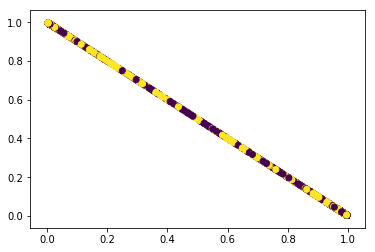

In [31]:
dec_whole_model_pred = dec_model.model.predict(train_features)
plt.scatter(dec_whole_model_pred[:, 0], dec_whole_model_pred[:, 1], c=train_labels)
plt.savefig(f'../data/figs/clustering_features.png')

#### Encoder Output Features

CPU times: user 6.45 s, sys: 1.26 s, total: 7.71 s
Wall time: 5.81 s


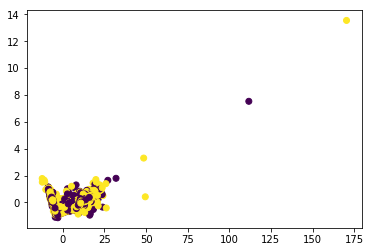

In [32]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
from sklearn.decomposition import PCA
pca_mod = PCA(2)
reduced_features = pca_mod.fit_transform(dec_encoder_model_pred)
#cond_arr = (reduced_features[:, 0] < 50) & (reduced_features[:, 1] < 6)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_labels)
plt.savefig(f'../data/figs/encoding_pca_features.png')